ly's code for batch dates

In [12]:
import pandas as pd

dataset1 = "Solar_flare_RHESSI_2004_05.csv"
df = pd.read_csv(dataset1)

start_date_set1 = pd.to_datetime('2004-01-01')
end_date_set1 = start_date_set1 + pd.DateOffset(months=24)

batch_size = pd.DateOffset(months=4)
overlap = pd.DateOffset(months=2)

batch_dates = []

current_start = start_date_set1
while current_start < end_date_set1:
    current_end = current_start + batch_size
    batch_dates.append((current_start, current_end))
    current_start = current_start + batch_size - overlap


for i, (batch_start, batch_end) in enumerate(batch_dates):
    print(f"Batch {i + 1}: {batch_start} - {batch_end}")

Batch 1: 2004-01-01 00:00:00 - 2004-05-01 00:00:00
Batch 2: 2004-03-01 00:00:00 - 2004-07-01 00:00:00
Batch 3: 2004-05-01 00:00:00 - 2004-09-01 00:00:00
Batch 4: 2004-07-01 00:00:00 - 2004-11-01 00:00:00
Batch 5: 2004-09-01 00:00:00 - 2005-01-01 00:00:00
Batch 6: 2004-11-01 00:00:00 - 2005-03-01 00:00:00
Batch 7: 2005-01-01 00:00:00 - 2005-05-01 00:00:00
Batch 8: 2005-03-01 00:00:00 - 2005-07-01 00:00:00
Batch 9: 2005-05-01 00:00:00 - 2005-09-01 00:00:00
Batch 10: 2005-07-01 00:00:00 - 2005-11-01 00:00:00
Batch 11: 2005-09-01 00:00:00 - 2006-01-01 00:00:00
Batch 12: 2005-11-01 00:00:00 - 2006-03-01 00:00:00


method 2 (2004-2005 , first dour months)

Q1: Intensity = 3184392.71
Q2: Intensity = 6403524.02
Q3: Intensity = 3556874.78
Q4: Intensity = 836848.17
Q5: Intensity = 785114.61
Q6: Intensity = 472481.24
Q7: Intensity = 317876.10


c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


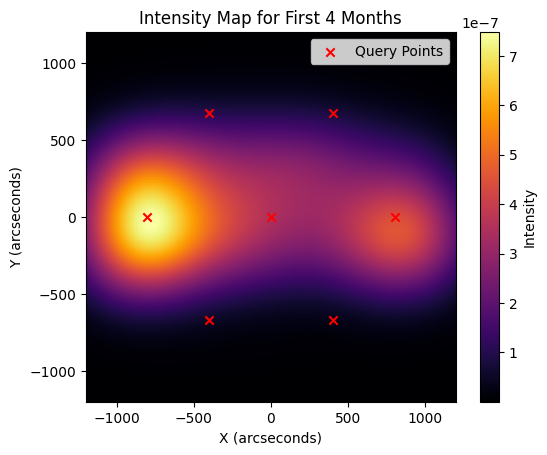

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV



dataset1 = "Solar_flare_RHESSI_2004_05.csv"

data = pd.read_csv(dataset1)

data['dt.start'] = pd.to_datetime(data['dt.start'])
start_date = pd.to_datetime('2004-01-01')
end_date = start_date + pd.DateOffset(months = 4)
data = data[(data['dt.start'] >= start_date) & (data['dt.start'] <= end_date)]
data = data[['duration.s', 'energy.kev', 'x.pos.asec', 'y.pos.asec']]

flare_events = data

# query points
query_points = {
    'Q1': {'coordinates': (0, 0), 'range': ([-201, 201], [-335, 335])},
    'Q2': {'coordinates': (-805, 0), 'range': ([-1007, -605], [-335, 335])},
    'Q3': {'coordinates': (805, 0), 'range': ([605, 1005], [-355, 335])},
    'Q4': {'coordinates': (-403, 674), 'range': ([-605, -201], [335, 1012])},
    'Q5': {'coordinates': (403, 674), 'range': ([201, 605], [335, 1012])},
    'Q6': {'coordinates': (-403, -667), 'range': ([-605, -201], [-335, -998])},
    'Q7': {'coordinates': (403, -667), 'range': ([201, 605], [-335, -998])},
}


# Gaussian kernel function
def gaussian_kernel(x, y, X, Y, sigma):
    return np.exp(-((x - X)**2 + (y - Y)**2) / (2 * sigma**2))

# Estimate intensity at each query point
def estimate_intensity(query_points, flare_events, sigma):
    estimated_intensities = []
    for query_name, query_info in query_points.items():
        X_q, Y_q = query_info['coordinates']
        intensity = 0
        for _, row in flare_events.iterrows():
            X_i, Y_i, duration_s, energy_band_range = row['x.pos.asec'], row['y.pos.asec'], row['duration.s'], row['energy.kev']

            # i used the average energy in the band
            energy_band_start, energy_band_end = map(int, energy_band_range.split('-'))
            energy_kev = (energy_band_start + energy_band_end) / 2
            intensity += duration_s * energy_kev * gaussian_kernel(X_q, Y_q, X_i, Y_i, sigma)

        estimated_intensities.append((query_name, intensity))
    return estimated_intensities

    
sigma = 250.0

# Estimate intensity at query points
intensities = estimate_intensity(query_points, flare_events, sigma)

# Print the estimated intensities
for query_name, intensity in intensities:
    print(f"{query_name}: Intensity = {intensity:.2f}")

# Create a grid for the density map
x_min, x_max = -1200, 1200 
y_min, y_max = -1200, 1200  
step = 10  

xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

# Create a KDE model 
kde = KernelDensity(bandwidth=sigma, kernel='gaussian')
kde.fit(flare_events[['x.pos.asec', 'y.pos.asec']])  

# Calculate the log-densities at each point on the grid
log_densities = kde.score_samples(grid_points)

density_map = np.exp(log_densities).reshape(xx.shape)

# Create the density map
plt.imshow(density_map, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='inferno')
plt.colorbar(label='Intensity')
plt.scatter([p['coordinates'][0] for p in query_points.values()], [p['coordinates'][1] for p in query_points.values()], color='red', marker='x', label='Query Points')

# labels and legend
plt.xlabel('X (arcseconds)')
plt.ylabel('Y (arcseconds)')
plt.title('Intensity Map for First 4 Months')
plt.legend()


plt.show()

method 2 for the 2004-2005 dataset (LAST FOUR MONTHS)

Q1: Intensity = 2433170.36
Q2: Intensity = 4647647.30
Q3: Intensity = 2007070.05
Q4: Intensity = 116862.39
Q5: Intensity = 21288.69
Q6: Intensity = 1197701.27
Q7: Intensity = 666478.91


c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


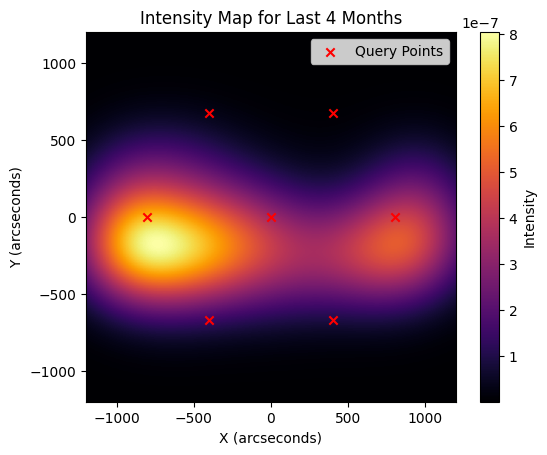

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV



dataset1 = "Solar_flare_RHESSI_2004_05.csv"

data = pd.read_csv(dataset1)

data['dt.start'] = pd.to_datetime(data['dt.start'])
start_date = pd.to_datetime('2005-09-01')
end_date = start_date + pd.DateOffset(months = 4)
data = data[(data['dt.start'] >= start_date) & (data['dt.start'] <= end_date)]
data = data[['duration.s', 'energy.kev', 'x.pos.asec', 'y.pos.asec']]

flare_events = data

# query points
query_points = {
    'Q1': {'coordinates': (0, 0), 'range': ([-201, 201], [-335, 335])},
    'Q2': {'coordinates': (-805, 0), 'range': ([-1007, -605], [-335, 335])},
    'Q3': {'coordinates': (805, 0), 'range': ([605, 1005], [-355, 335])},
    'Q4': {'coordinates': (-403, 674), 'range': ([-605, -201], [335, 1012])},
    'Q5': {'coordinates': (403, 674), 'range': ([201, 605], [335, 1012])},
    'Q6': {'coordinates': (-403, -667), 'range': ([-605, -201], [-335, -998])},
    'Q7': {'coordinates': (403, -667), 'range': ([201, 605], [-335, -998])},
}


# Gaussian kernel function
def gaussian_kernel(x, y, X, Y, sigma):
    return np.exp(-((x - X)**2 + (y - Y)**2) / (2 * sigma**2))

# Estimate intensity at each query point
def estimate_intensity(query_points, flare_events, sigma):
    estimated_intensities = []
    for query_name, query_info in query_points.items():
        X_q, Y_q = query_info['coordinates']
        intensity = 0
        for _, row in flare_events.iterrows():
            X_i, Y_i, duration_s, energy_band_range = row['x.pos.asec'], row['y.pos.asec'], row['duration.s'], row['energy.kev']

            # i used the average energy in the band
            energy_band_start, energy_band_end = map(int, energy_band_range.split('-'))
            energy_kev = (energy_band_start + energy_band_end) / 2
            intensity += duration_s * energy_kev * gaussian_kernel(X_q, Y_q, X_i, Y_i, sigma)

        estimated_intensities.append((query_name, intensity))
    return estimated_intensities


    
sigma = 250.0

# Estimate intensity at query points
intensities = estimate_intensity(query_points, flare_events, sigma)

# Print the estimated intensities
for query_name, intensity in intensities:
    print(f"{query_name}: Intensity = {intensity:.2f}")

# Create a grid for the density map
x_min, x_max = -1200, 1200 
y_min, y_max = -1200, 1200  
step = 10  

xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

# Create a KDE model 
kde = KernelDensity(bandwidth=sigma, kernel='gaussian')
kde.fit(flare_events[['x.pos.asec', 'y.pos.asec']])  

# Calculate the log-densities at each point on the grid
log_densities = kde.score_samples(grid_points)

density_map = np.exp(log_densities).reshape(xx.shape)

# Create the density map
plt.imshow(density_map, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='inferno')
plt.colorbar(label='Intensity')
plt.scatter([p['coordinates'][0] for p in query_points.values()], [p['coordinates'][1] for p in query_points.values()], color='red', marker='x', label='Query Points')

# labels and legend
plt.xlabel('X (arcseconds)')
plt.ylabel('Y (arcseconds)')
plt.title('Intensity Map for Last 4 Months')
plt.legend()


plt.show()

ly's code for batch dates

In [15]:
import pandas as pd

dataset2 = "Solar_flare_RHESSI_2015_16.csv"
data = pd.read_csv(dataset2)

start_date_set2 = pd.to_datetime('2015-01-01')
end_date_set2 = start_date_set2 + pd.DateOffset(months=24)

batch_size = pd.DateOffset(months=4)
overlap = pd.DateOffset(months=2)

batch_dates = []

current_start = start_date_set2
while current_start < end_date_set2:
    current_end = current_start + batch_size
    batch_dates.append((current_start, current_end))
    current_start = current_start + batch_size - overlap


for i, (batch_start, batch_end) in enumerate(batch_dates):
    print(f"Batch {i + 1}: {batch_start} - {batch_end}")

Batch 1: 2015-01-01 00:00:00 - 2015-05-01 00:00:00
Batch 2: 2015-03-01 00:00:00 - 2015-07-01 00:00:00
Batch 3: 2015-05-01 00:00:00 - 2015-09-01 00:00:00
Batch 4: 2015-07-01 00:00:00 - 2015-11-01 00:00:00
Batch 5: 2015-09-01 00:00:00 - 2016-01-01 00:00:00
Batch 6: 2015-11-01 00:00:00 - 2016-03-01 00:00:00
Batch 7: 2016-01-01 00:00:00 - 2016-05-01 00:00:00
Batch 8: 2016-03-01 00:00:00 - 2016-07-01 00:00:00
Batch 9: 2016-05-01 00:00:00 - 2016-09-01 00:00:00
Batch 10: 2016-07-01 00:00:00 - 2016-11-01 00:00:00
Batch 11: 2016-09-01 00:00:00 - 2017-01-01 00:00:00
Batch 12: 2016-11-01 00:00:00 - 2017-03-01 00:00:00


method 2 (2015-2016, first four months)

Q1: Intensity = 4199229.42
Q2: Intensity = 5581060.88
Q3: Intensity = 9331348.80
Q4: Intensity = 644005.94
Q5: Intensity = 1007702.58
Q6: Intensity = 741194.72
Q7: Intensity = 593380.21


c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


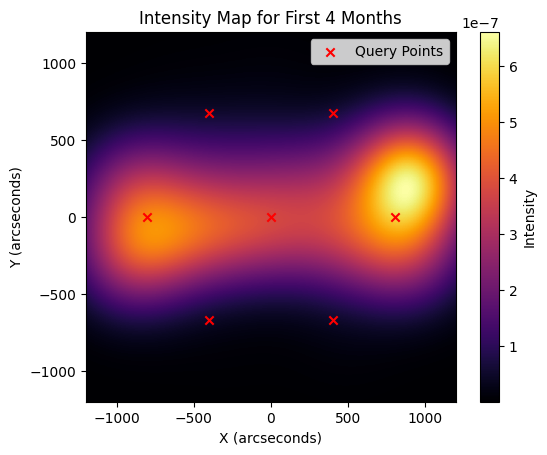

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV



dataset2 = "Solar_flare_RHESSI_2015_16.csv"

data = pd.read_csv(dataset2)

data['dt.start'] = pd.to_datetime(data['dt.start'])
start_date = pd.to_datetime('2015-01-01')
end_date = start_date + pd.DateOffset(months = 4)
data = data[(data['dt.start'] >= start_date) & (data['dt.start'] <= end_date)]
data = data[['energy.kev','duration.s', 'x.pos.asec', 'y.pos.asec']]

flare_events = data

# query points
query_points = {
    'Q1': {'coordinates': (0, 0), 'range': ([-201, 201], [-335, 335])},
    'Q2': {'coordinates': (-805, 0), 'range': ([-1007, -605], [-335, 335])},
    'Q3': {'coordinates': (805, 0), 'range': ([605, 1005], [-355, 335])},
    'Q4': {'coordinates': (-403, 674), 'range': ([-605, -201], [335, 1012])},
    'Q5': {'coordinates': (403, 674), 'range': ([201, 605], [335, 1012])},
    'Q6': {'coordinates': (-403, -667), 'range': ([-605, -201], [-335, -998])},
    'Q7': {'coordinates': (403, -667), 'range': ([201, 605], [-335, -998])},
}


# Gaussian kernel function
def gaussian_kernel(x, y, X, Y, sigma):
    return np.exp(-((x - X)**2 + (y - Y)**2) / (2 * sigma**2))

# Estimate intensity at each query point
def estimate_intensity(query_points, flare_events, sigma):
    estimated_intensities = []
    for query_name, query_info in query_points.items():
        X_q, Y_q = query_info['coordinates']
        intensity = 0
        for _, row in flare_events.iterrows():
            X_i, Y_i, duration_s, energy_band_range = row['x.pos.asec'], row['y.pos.asec'], row['duration.s'], row['energy.kev']

            # i used the average energy in the band
            energy_band_start, energy_band_end = map(int, energy_band_range.split('-'))
            energy_kev = (energy_band_start + energy_band_end) / 2
            intensity += duration_s * energy_kev * gaussian_kernel(X_q, Y_q, X_i, Y_i, sigma)

        estimated_intensities.append((query_name, intensity))
    return estimated_intensities

    
sigma = 250.0

# Estimate intensity at query points
intensities = estimate_intensity(query_points, flare_events, sigma)

# Print the estimated intensities
for query_name, intensity in intensities:
    print(f"{query_name}: Intensity = {intensity:.2f}")

# Create a grid for the density map
x_min, x_max = -1200, 1200 
y_min, y_max = -1200, 1200  
step = 10  

xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

# Create a KDE model 
kde = KernelDensity(bandwidth=sigma, kernel='gaussian')
kde.fit(flare_events[['x.pos.asec', 'y.pos.asec']])  

# Calculate the log-densities at each point on the grid
log_densities = kde.score_samples(grid_points)

density_map = np.exp(log_densities).reshape(xx.shape)

# Create the density map
plt.imshow(density_map, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='inferno')
plt.colorbar(label='Intensity')
plt.scatter([p['coordinates'][0] for p in query_points.values()], [p['coordinates'][1] for p in query_points.values()], color='red', marker='x', label='Query Points')

# labels and legend
plt.xlabel('X (arcseconds)')
plt.ylabel('Y (arcseconds)')
plt.title('Intensity Map for First 4 Months')
plt.legend()


plt.show()

method 2 (2015-2016, last four months)

Q1: Intensity = 532485.86
Q2: Intensity = 1787897.58
Q3: Intensity = 1235438.58
Q4: Intensity = 27397.83
Q5: Intensity = 47570.28
Q6: Intensity = 84760.60
Q7: Intensity = 209534.30


c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


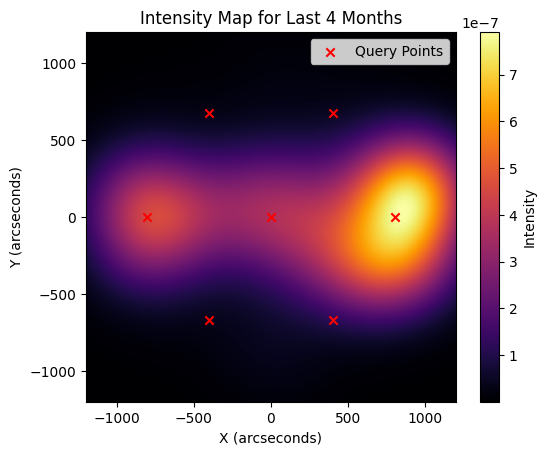

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV



dataset2 = "Solar_flare_RHESSI_2015_16.csv"

data = pd.read_csv(dataset2)

data['dt.start'] = pd.to_datetime(data['dt.start'])
start_date = pd.to_datetime('2016-09-01')
end_date = start_date + pd.DateOffset(months = 4)
data = data[(data['dt.start'] >= start_date) & (data['dt.start'] <= end_date)]
data = data[['energy.kev','duration.s', 'x.pos.asec', 'y.pos.asec']]

flare_events = data

# query points
query_points = {
    'Q1': {'coordinates': (0, 0), 'range': ([-201, 201], [-335, 335])},
    'Q2': {'coordinates': (-805, 0), 'range': ([-1007, -605], [-335, 335])},
    'Q3': {'coordinates': (805, 0), 'range': ([605, 1005], [-355, 335])},
    'Q4': {'coordinates': (-403, 674), 'range': ([-605, -201], [335, 1012])},
    'Q5': {'coordinates': (403, 674), 'range': ([201, 605], [335, 1012])},
    'Q6': {'coordinates': (-403, -667), 'range': ([-605, -201], [-335, -998])},
    'Q7': {'coordinates': (403, -667), 'range': ([201, 605], [-335, -998])},
}


# Gaussian kernel function
def gaussian_kernel(x, y, X, Y, sigma):
    return np.exp(-((x - X)**2 + (y - Y)**2) / (2 * sigma**2))

# Estimate intensity at each query point
def estimate_intensity(query_points, flare_events, sigma):
    estimated_intensities = []
    for query_name, query_info in query_points.items():
        X_q, Y_q = query_info['coordinates']
        intensity = 0
        for _, row in flare_events.iterrows():
            X_i, Y_i, duration_s, energy_band_range = row['x.pos.asec'], row['y.pos.asec'], row['duration.s'], row['energy.kev']

            # i used the average energy in the band
            energy_band_start, energy_band_end = map(int, energy_band_range.split('-'))
            energy_kev = (energy_band_start + energy_band_end) / 2
            intensity += duration_s * energy_kev * gaussian_kernel(X_q, Y_q, X_i, Y_i, sigma)

        estimated_intensities.append((query_name, intensity))
    return estimated_intensities

    
sigma = 250.0

# Estimate intensity at query points
intensities = estimate_intensity(query_points, flare_events, sigma)

# Print the estimated intensities
for query_name, intensity in intensities:
    print(f"{query_name}: Intensity = {intensity:.2f}")

# Create a grid for the density map
x_min, x_max = -1200, 1200 
y_min, y_max = -1200, 1200  
step = 10  

xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

# Create a KDE model 
kde = KernelDensity(bandwidth=sigma, kernel='gaussian')
kde.fit(flare_events[['x.pos.asec', 'y.pos.asec']])  

# Calculate the log-densities at each point on the grid
log_densities = kde.score_samples(grid_points)

density_map = np.exp(log_densities).reshape(xx.shape)

# Create the density map
plt.imshow(density_map, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='inferno')
plt.colorbar(label='Intensity')
plt.scatter([p['coordinates'][0] for p in query_points.values()], [p['coordinates'][1] for p in query_points.values()], color='red', marker='x', label='Query Points')

# labels and legend
plt.xlabel('X (arcseconds)')
plt.ylabel('Y (arcseconds)')
plt.title('Intensity Map for Last 4 Months')
plt.legend()


plt.show()